In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [5]:
df = pd.read_csv("data/project_tsibble.csv")
df.head()

,ffc_band,yearmonth(bca),Total
0,10-20,2016 Feb,1
1,10-20,2016 Mar,0
2,10-20,2016 Apr,0
3,10-20,2016 May,0
4,10-20,2016 Jun,0


# Convert to dates

In [6]:
df["Timeline"] = pd.to_datetime(df['yearmonth(bca)']).dt.date

/var/folders/bl/615qdshd0qj1cddydmjsmf800000gn/T/ipykernel_66304/1694602386.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Timeline"] = pd.to_datetime(df['yearmonth(bca)']).dt.date


In [7]:
df = df.drop('yearmonth(bca)',axis = 1) # Removing yearmonth column



In [8]:
df = df[["Timeline","ffc_band","Total"]]  # Rearranging all columns
df

,Timeline,ffc_band,Total
0,2016-02-01,10-20,1
1,2016-03-01,10-20,0
2,2016-04-01,10-20,0
3,2016-05-01,10-20,0
4,2016-06-01,10-20,0
...,...,...,...
909,2030-08-01,> 80,0
910,2030-09-01,> 80,0
911,2030-10-01,> 80,0
912,2030-11-01,> 80,0


# Filtering the data to keep only projects with FFC_band < 5 mil 

In [9]:
df = df[df['ffc_band'] == "< = 5"]
values = df['Total'].values

# Normalise data using MinMax scaling

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values.reshape(-1, 1))

# Sequence creation for training

In [11]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 5  # Number of time steps
X, y = create_sequences(scaled_values, SEQ_LENGTH)

# Split into training and test sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Building the LSTM 

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model

In [13]:
BATCH_SIZE = 5  # or 8
SEQ_LENGTH = 3   # Try reducing this

X, y = create_sequences(scaled_values, SEQ_LENGTH)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Rebuild model with updated parameters
model = Sequential([
    LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model with reduced batch size
history = model.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/50


2024-08-15 16:46:19.695140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 4s 99ms/step - loss: 0.0995 - val_loss: 0.0042
Epoch 2/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0658 - val_loss: 0.0221
Epoch 3/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0523 - val_loss: 0.0362
Epoch 4/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0525 - val_loss: 0.0315
Epoch 5/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0522 - val_loss: 0.0310
Epoch 6/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0521 - val_loss: 0.0301
Epoch 7/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0518 - val_loss: 0.0315
Epoch 8/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0527 - val_loss: 0.0285
Epoch 9/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0519 - val_loss: 0.0303
Epoch 10/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0518 - val_loss: 0.0320
Epoch 11/50
23/23 [=

# Testing

1/1 [==============================] - 0s 42ms/step - loss: 0.0051
Test Loss: 0.005105860065668821
1/1 [==============================] - 0s 351ms/step


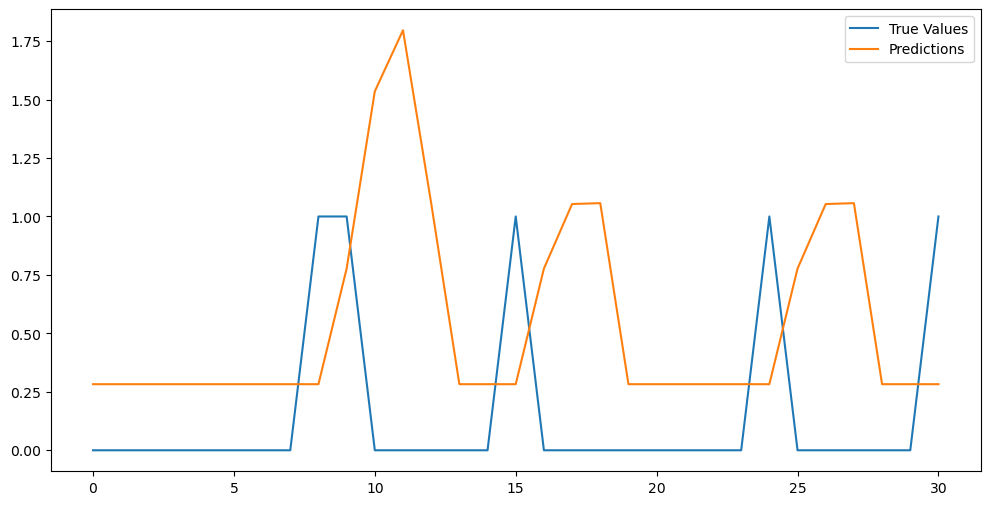

In [14]:
import matplotlib.pyplot as plt

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform to original scale
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test)), y_test, label='True Values')
plt.plot(np.arange(len(predictions)), predictions, label='Predictions')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predictions and true values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

1/1 [==============================] - 0s 12ms/step
Mean Absolute Error (MAE): 2.0342
Mean Squared Error (MSE): 15.3706
Root Mean Squared Error (RMSE): 3.9205
